# Telco Customer Churn Prediction: An End to End Analysis
Objective
The primary goal is to maximize **Recall** for the churn class (True Positives) to ensure the maximum number of high-risk customers are identified for proactive retention campaigns. The final model uses an **XGBoost Classifier** optimized for the F1-Score threshold.


In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
import xgboost as xgb

# Set plot style and display options
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


In [3]:
# Data Loading and Initial Cleaning 
telco_df = pd.read_csv('../data/Telco-Churn.csv')

# Convert TotalCharges to numeric, coercing errors and filling resulting NaNs
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')
telco_df['TotalCharges'].fillna(telco_df['TotalCharges'].median(), inplace=True)

# Map target variable (Churn) to 1/0
telco_df['Churn'] = telco_df['Churn'].map({'Yes': 1, 'No': 0})
print("Data loaded and TotalCharges handled. Target Churn mapped to 1/0.")
print(f"Churn Ratio: {telco_df['Churn'].mean():.2f}")


Data loaded and TotalCharges handled. Target Churn mapped to 1/0.
Churn Ratio: 0.27


C:\Users\akolade\AppData\Local\Temp\ipykernel_14884\2421382182.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco_df['TotalCharges'].fillna(telco_df['TotalCharges'].median(), inplace=True)


## Feature Engineering: Creating Predictive Signals
To improve the model's performance, several new features were engineered based on EDA insights.


In [4]:
# Feature Engineering:
# Tenure Groups (Categorical signal for customer loyalty stages)
telco_df["tenure_group"] = pd.cut(
    telco_df["tenure"], bins=[0, 12, 24, 48, 72],
    labels=["0-1yrs", "1-2yrs", "2-4yrs", "4-6yrs"], right=False, include_lowest=True
)

# Is New Customer (Binary indicator for high-risk first year)
telco_df["is_new_customer"] = (telco_df["tenure"] <= 12).astype(int)

# Number of Services (Composite score of total services)
servicce_features = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                     'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Clean and convert service features before summing
for col in servicce_features:
    if col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies']:
        telco_df[col] = telco_df[col].replace({'No internet service': 'No', 'Yes': 'Yes', 'No': 'No'})

# Re-map Yes/No features to 1/0
cols_to_map = ['Partner', 'Dependents', 'PaperlessBilling'] + servicce_features
for col in cols_to_map:
     if telco_df[col].dtype == 'object':
         telco_df[col] = telco_df[col].map({'Yes': 1, 'No': 0})

telco_df["num_services"] = telco_df[servicce_features].sum(axis=1)


# Exploratory Data Analysis (EDA) Highlights
The following visualizations show the strongest predictors of churn, which validate the need for the engineered features.


C:\Users\akolade\AppData\Local\Temp\ipykernel_14884\499321932.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contract_churn.index, y=contract_churn.values, palette='viridis')


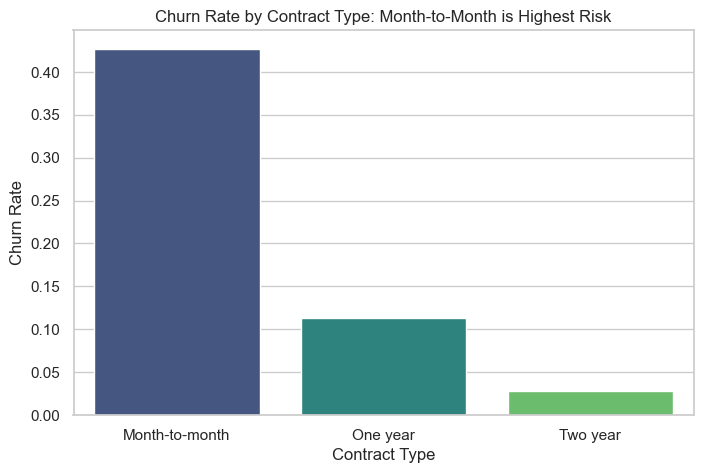

C:\Users\akolade\AppData\Local\Temp\ipykernel_14884\499321932.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = telco_df.groupby('tenure_group')['Churn'].mean().sort_values(ascending=False)
C:\Users\akolade\AppData\Local\Temp\ipykernel_14884\499321932.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tenure_churn.index, y=tenure_churn.values, palette='viridis')


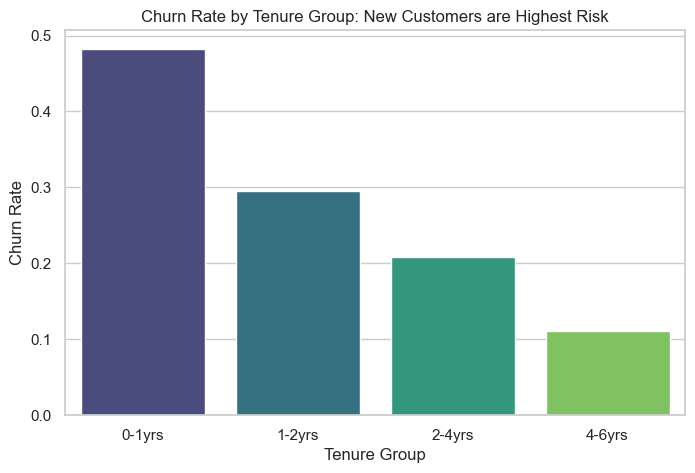

C:\Users\akolade\AppData\Local\Temp\ipykernel_14884\499321932.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=senior_churn.index, y=senior_churn.values, palette='viridis')


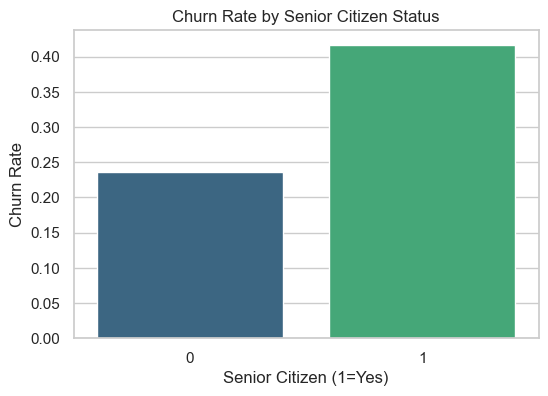

In [5]:
# EDA: Churn Rate by Contract Type (The most predictive feature)
contract_churn = telco_df.groupby('Contract')['Churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=contract_churn.index, y=contract_churn.values, palette='viridis')
plt.title('Churn Rate by Contract Type: Month-to-Month is Highest Risk')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.show()

# EDA: Churn Rate by Tenure Group
tenure_churn = telco_df.groupby('tenure_group')['Churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=tenure_churn.index, y=tenure_churn.values, palette='viridis')
plt.title('Churn Rate by Tenure Group: New Customers are Highest Risk')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.show()

# EDA: Churn Rate by Senior Citizen Status
senior_churn = telco_df.groupby('SeniorCitizen')['Churn'].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=senior_churn.index, y=senior_churn.values, palette='viridis')
plt.title('Churn Rate by Senior Citizen Status')
plt.xlabel('Senior Citizen (1=Yes)')
plt.ylabel('Churn Rate')
plt.show()


# Final Model Preprocessing Pipeline
The final steps to prepare data for the model involve splitting, scaling numerical features, and one-hot encoding categorical features.


In [6]:
# Define final feature sets
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'num_services']
categorical_cols = telco_df.select_dtypes(include='object').columns.tolist() + ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'tenure_group']

# Remove the customer ID and target from the categorical list
categorical_cols = [col for col in categorical_cols if col not in ['customerID']]

# Split Data (using the same split ratio as your experiments)
X = telco_df.drop(columns=['customerID', 'Churn'])
y = telco_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) # Using a 15% test set for simplicity

# Preprocessing Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)


# Optimized XGBoost Evaluation (Final Results)
The final model is an XGBoost Classifier trained with **class weights** to favor Recall and evaluated at the F1-Score optimal threshold (found at $\approx 0.5503$).
**Note:** The full hyperparameter search steps are documented in the model development logs. The final, clean code is available in **`src/model_pipeline.py`**.


In [7]:
# Final Model Setup (Using Tuned Parameters)
# Calculate class weight ratio
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost with tuned parameters and class weight
xgb_tuned = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,  # Based on typical tuning results
    max_depth=5,
    n_estimators=200,
    scale_pos_weight=ratio, 
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_tuned)
])

# Fit the final model
final_pipeline.fit(X_train, y_train)

# Get probabilities
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Re-compute F1 optimal threshold for validation (as done in the original code)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

# Apply the F1-optimized threshold
OPTIMAL_THRESHOLD = best_f1_threshold
y_pred_adj = (y_proba >= OPTIMAL_THRESHOLD).astype(int)



c:\Users\akolade\miniconda3\lib\site-packages\xgboost\training.py:199: UserWarning: [19:04:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Optimal Classification Threshold (Max F1): 0.5222
ROC AUC Score: 0.8445

--- Classification Report (Adjusted Threshold) ---
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       777
           1       0.54      0.78      0.64       280

    accuracy                           0.77      1057
   macro avg       0.72      0.77      0.73      1057
weighted avg       0.81      0.77      0.78      1057

--- Confusion Matrix ---
[[590 187]
 [ 61 219]]


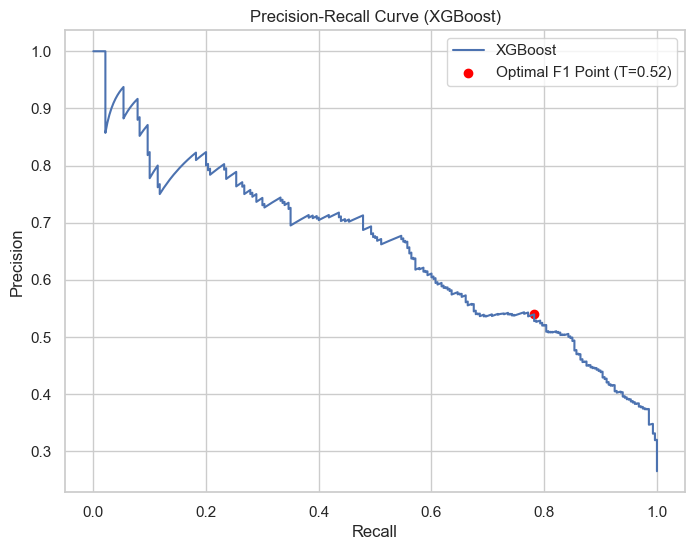

In [8]:
# Final Metrics and Visualization
print(f"Optimal Classification Threshold (Max F1): {OPTIMAL_THRESHOLD:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

print("\n--- Classification Report (Adjusted Threshold) ---")
print(classification_report(y_test, y_pred_adj))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_adj))

# Precision-Recall Curve Visualization
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label='XGBoost')
plt.scatter(recalls[best_f1_idx], precisions[best_f1_idx], marker='o', color='red', label=f'Optimal F1 Point (T={OPTIMAL_THRESHOLD:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()